In [1]:
import numpy as np
import torch
from itertools import product
import matplotlib.pyplot as plt
from dataclasses import dataclass
import random
from enviroments import env_red, P_j, P_j_dist, env_red_p2p, env_red_toy
import pickle
from algorithms.Action_Gen import Action_generation
from algorithms.RDQL import action_space_generation, ini_action_list, caculate_op_cost,update_action_space
from algorithms.DQL import DQL_algorithm, select_action
from algorithms.QL_LowRank import select_action as select_action_LR

NUMERO_DE_NUCLEOS = 16

torch.set_num_threads(NUMERO_DE_NUCLEOS)

In [2]:
def sim_trayectorias(env,Qfun,num_sim,max_steps,nA,model = "NN"):
    Rs = []
    r_t= []
    s_t = []
    a_t = []

    for episode in range(num_sim):
        s, _ = env.set_initial(s = [0,0])
        R = 0
        for step in range(max_steps):

            if model == "NN":
                a = select_action(Qfun, s, 0, nA)
            if model == "LR":
                a = select_action_LR(Qfun, s, 0, len(env.action_space))

            s_prime, r, done, _, _ = env.step(a)
            
            r_t.append(r)
            s_t.append(s)
            a_t.append(a) 

            R += r

            if done:
                break
                
            s = s_prime
        Rs.append(R)
    return Rs, r_t, s_t, a_t
    

In [3]:
env  =  env_red_toy()
num_sim = 10000
max_steps = 100

nS = env.I + 1
nA = len(env.action_space)
nH = 128

In [4]:
# DQL
qnet = torch.nn.Sequential(
    torch.nn.Linear(nS, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nA)
).double()

qnet.load_state_dict(torch.load("exp_toy_result/qnet_toy.pth"))

Rs, r_t, _, _ = sim_trayectorias(env,qnet,num_sim,max_steps,nA)

In [5]:
# Action_Gen - RDQN
with open('results/AG_actions.pkl', 'rb') as archivo:
    a_space = pickle.load(archivo)

env.action_space = a_space
nS = 3
nA = len(a_space)
nH = 128

qnet = torch.nn.Sequential(
    torch.nn.Linear(nS, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nA)
).double()

qnet.load_state_dict(torch.load('exp_toy_result/qnet_AG_toy.pth'))

Rs1, r_t1, _, _ = sim_trayectorias(env,qnet,num_sim,max_steps,nA)

In [6]:
# Low-Rank
class QfunPARAFAC(torch.nn.Module):
    def __init__(self, dims, k, scale=1.0):
        super().__init__()

        self.k = k
        self.n_factors = len(dims)

        factors = []
        for dim in dims:
            factor = scale*torch.randn(dim, k, dtype=torch.double, requires_grad=True)
            factors.append(torch.nn.Parameter(factor))
        self.factors = torch.nn.ParameterList(factors)

    def forward(self, indices):
        bsz = indices.shape[0]
        if indices.shape[0] == 4:
            print(indices.shape[1])
        prod = torch.ones(bsz, self.k, dtype=torch.double)
        for i in range(indices.shape[1]):
            idx = indices[:, i]
            factor = self.factors[i]
            prod *= factor[idx, :]
        if indices.shape[1] < len(self.factors):
            return torch.matmul(prod, self.factors[-1].T)
        return torch.sum(prod, dim=-1)

env = env_red_toy()

dims = [env.C[0]+1, env.C[1]+1,env.T+1, len(env.action_space)]
qtensor = QfunPARAFAC(dims= dims, k = 5, scale= 0.1)

qtensor.load_state_dict(torch.load('exp_toy_result/qtensor_toy.pth'))

Rs2, r_t2, _, _ = sim_trayectorias(env,qtensor,num_sim,max_steps,nA, model="LR")

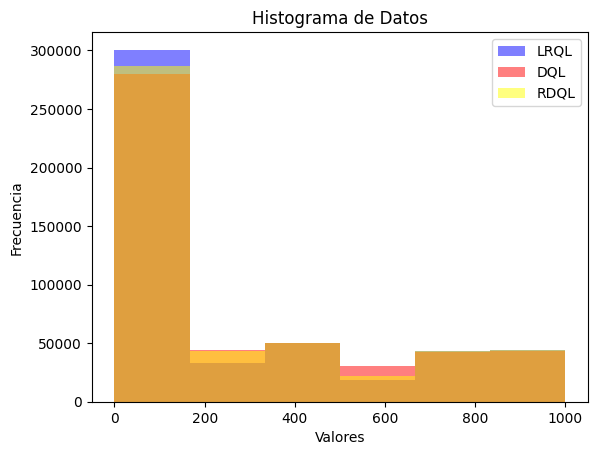

In [7]:
plt.hist(r_t2, bins=env.J, alpha=0.5, color='blue',label="LRQL")  # 'bins' determina la cantidad de divisiones en el histograma
plt.hist(r_t, bins=env.J, alpha=0.5, color='red',label="DQL")  # 'bins' determina la cantidad de divisiones en el histograma
plt.hist(r_t1, bins=env.J, alpha=0.5, color='yellow',label="RDQL")  # 'bins' determina la cantidad de divisiones en el histograma

plt.title('Histograma de Datos')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

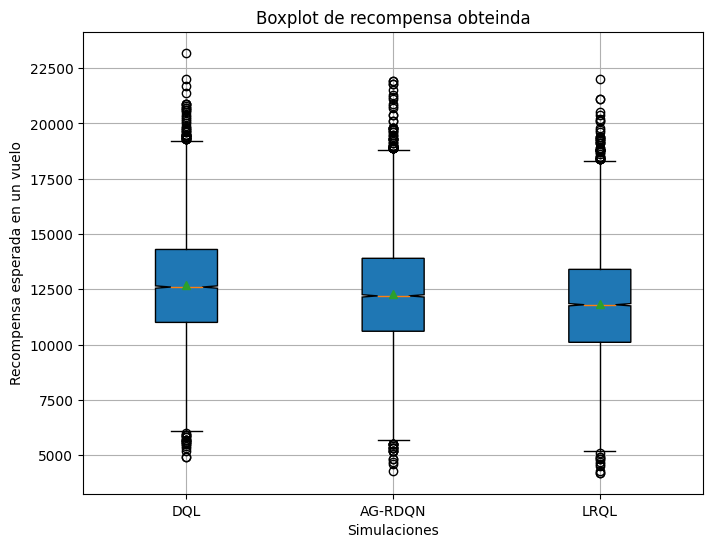

In [8]:
datos = [Rs, Rs1, Rs2]
plt.figure(figsize=(8, 6))
plt.boxplot(datos, patch_artist=True, notch=True, showmeans=True)

plt.title('Boxplot de recompensa obteinda')
plt.xlabel('Simulaciones')
plt.ylabel('Recompensa esperada en un vuelo')
plt.xticks([1, 2, 3], ['DQL', 'AG-RDQN', 'LRQL'])  # Cambiar etiquetas del eje x
plt.grid(True)

plt.show()